In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
import sklearn.linear_model
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import time
import keras
from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from statsmodels.tsa.seasonal import seasonal_decompose
import pydot 
import graphviz

In [6]:
raw_df = pd.read_csv("data/NYC_May18May19.csv")
print(f"The dataset contains {len(raw_df)} Airbnb listings")
pd.set_option('display.max_columns', len(raw_df.columns)) # To view all columns
pd.set_option('display.max_rows', 100)
raw_df.head(3)

The dataset contains 644496 Airbnb listings


,Column1,date,id,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count
0,0,5/9/18,2515,2758,Harlem,40.799205,-73.953676,Hotel room,59,2,3
1,1,5/9/18,2539,2787,Kensington,40.647486,-73.972370,Private room,79,1,7
2,2,5/9/18,2595,2845,Midtown,40.753621,-73.983774,Entire home/apt,225,1,2


In [7]:
raw_df.date = pd.to_datetime(raw_df.date) 
raw_df=raw_df.dropna()

In [8]:
raw_df=raw_df.drop(['Column1'], axis=1)
raw_df.head()

,date,id,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count
0,2018-05-09,2515,2758,Harlem,40.799205,-73.953676,Hotel room,59,2,3
1,2018-05-09,2539,2787,Kensington,40.647486,-73.972370,Private room,79,1,7
2,2018-05-09,2595,2845,Midtown,40.753621,-73.983774,Entire home/apt,225,1,2
3,2018-05-09,3330,4177,Williamsburg,40.708558,-73.942362,Private room,70,5,3
4,2018-05-09,3647,4632,Harlem,40.809018,-73.941902,Private room,150,3,1


In [9]:
raw_df.isna().sum()


date                              0
id                                0
host_id                           0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
calculated_host_listings_count    0
dtype: int64

In [10]:
raw_df.price.value_counts()

150     26871
100     26030
50      20629
60      19340
200     18524
        ...  
1265        1
754         1
1267        1
1779        1
3830        1
Name: price, Length: 997, dtype: int64

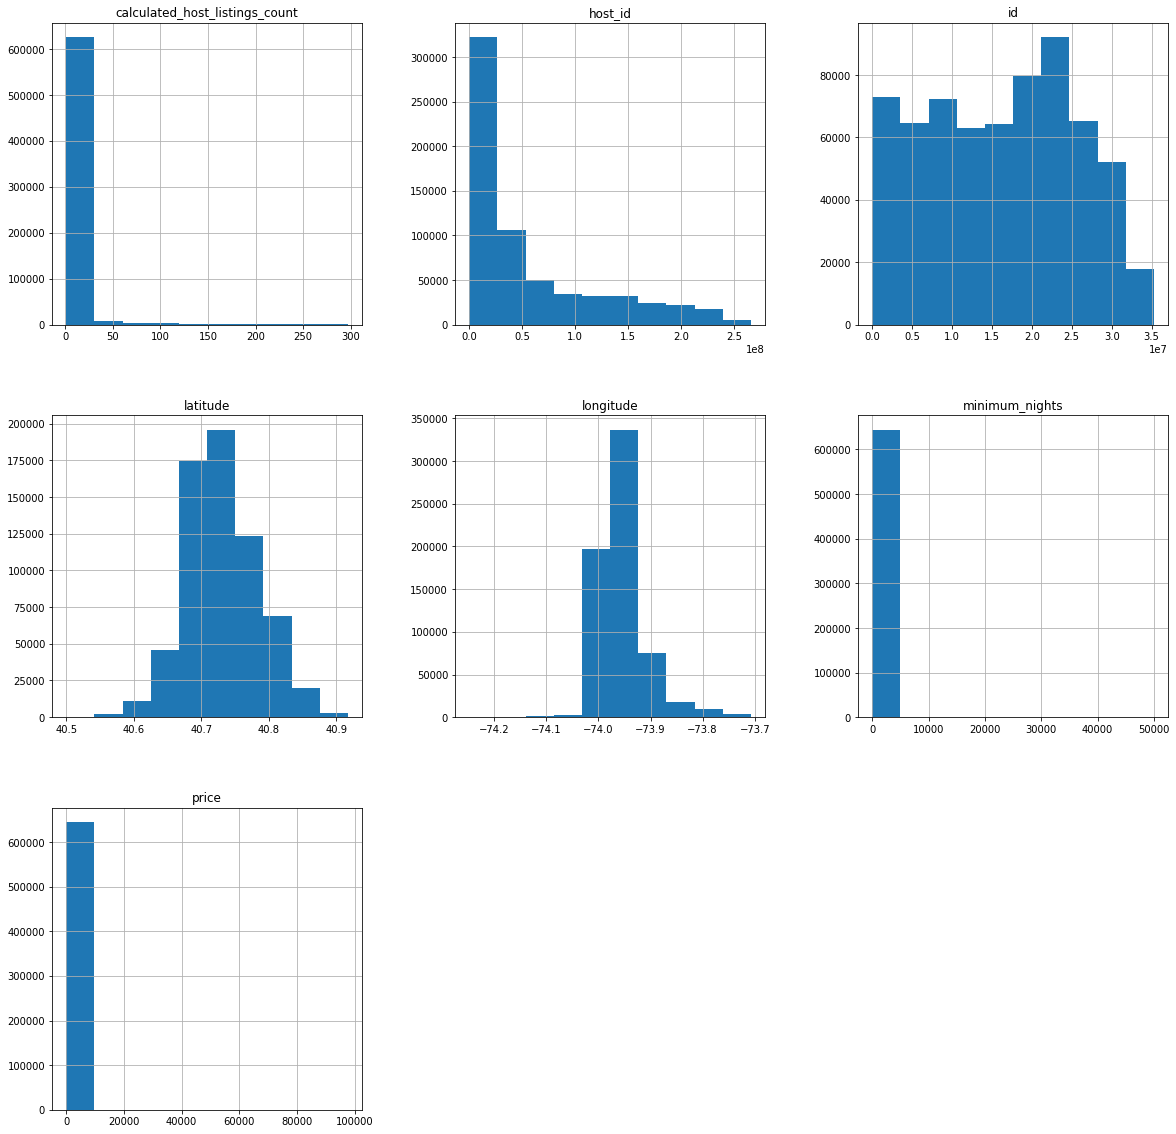

In [11]:
# Replacing columns with f/t with 0/1
raw_df.replace({'f': 0, 't': 1}, inplace=True)

# Plotting the distribution of numerical and boolean categories
raw_df.hist(figsize=(20,20));

In [12]:
raw_df.room_type.value_counts()


Entire home/apt    335277
Private room       294526
Shared room         14692
Hotel room              1
Name: room_type, dtype: int64

In [13]:
print("Mean nightly price of listings in each year on Airbnb in NYC:")
print(round(raw_df.set_index('date').price.resample('YS').mean(),2))

Mean nightly price of listings in each year on Airbnb in NYC:
date
2018-01-01    150.10
2019-01-01    152.02
Freq: AS-JAN, Name: price, dtype: float64


In [14]:
host_listings_count = raw_df.host_id.value_counts()
host_listings_count

107434423    1595
30283594     1471
22541573     1067
16098958     1032
219517861     964
             ... 
79653673        1
27335399        1
2599473         1
228024872       1
17913899        1
Name: host_id, Length: 59282, dtype: int64

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


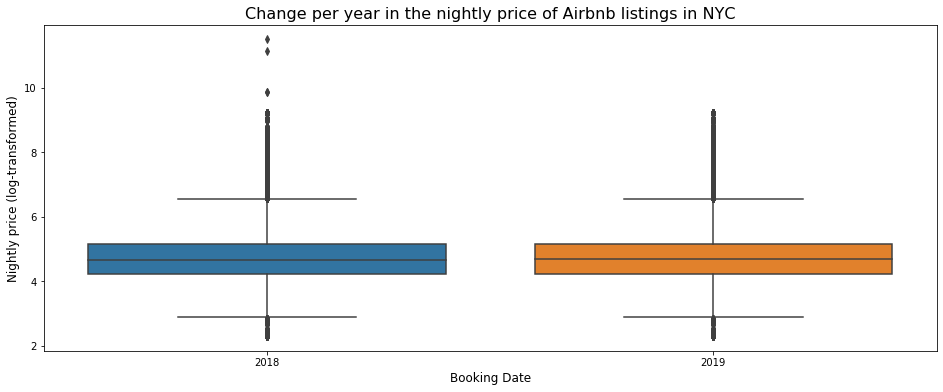

In [15]:
plt.figure(figsize=(16,6))
sns.boxplot(raw_df.date.dt.year, np.log(raw_df.price))
plt.xlabel('Booking Date', fontsize=12)
plt.ylabel('Nightly price (log-transformed)', fontsize=12)
plt.title('Change per year in the nightly price of Airbnb listings in NYC', fontsize=16)
plt.show()

In [16]:
raw_df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,calculated_host_listings_count
count,6.444960e+05,6.444960e+05,644496.000000,644496.000000,644496.000000,644496.000000,644496.000000
mean,1.620088e+07,5.550720e+07,40.729727,-73.953425,150.837322,6.817555,4.502957
std,9.270845e+06,6.421395e+07,0.053930,0.044322,270.246080,125.969881,17.532499
min,2.454000e+03,2.830000e+02,40.499790,-74.247874,0.000000,1.000000,1.000000
25%,8.303337e+06,7.040483e+06,40.690950,-73.983370,69.000000,1.000000,1.000000
50%,1.667857e+07,2.655670e+07,40.724054,-73.956466,105.000000,2.000000,1.000000
75%,2.346603e+07,8.375453e+07,40.763643,-73.938041,175.000000,5.000000,2.000000
max,3.530389e+07,2.657038e+08,40.917067,-73.707245,97598.000000,50000.000000,297.000000


In [17]:
print(f"Nightly advertised prices range from ${min(raw_df.price)} to ${max(raw_df.price)}.")


Nightly advertised prices range from $0 to $97598.


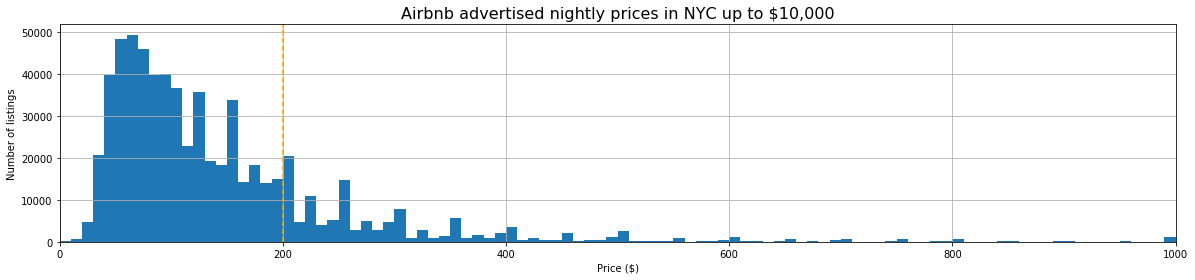

In [18]:
# Distribution of prices from $0 to $1000
plt.figure(figsize=(20,4))
raw_df.price.hist(bins=100, range=(0,1000))
plt.margins(x=0)
plt.axvline(200, color='orange', linestyle='--')
plt.title("Airbnb advertised nightly prices in NYC up to $10,000", fontsize=16)
plt.xlabel("Price ($)")
plt.ylabel("Number of listings")
plt.savefig('images/NYC_nightly prices.png')
plt.show()

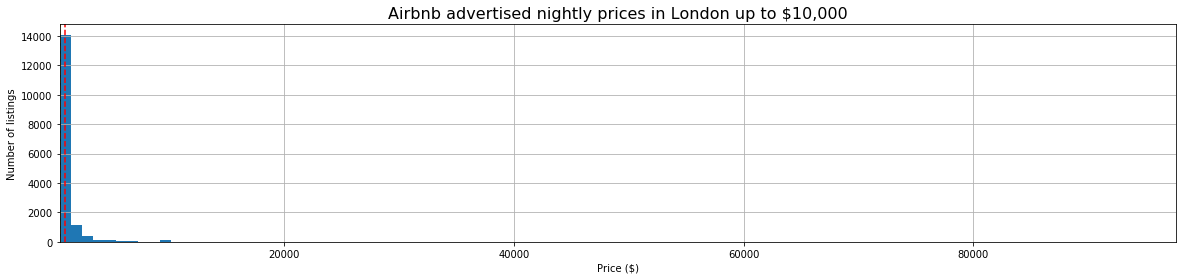

In [19]:
# Distribution of prices from $500 upwards
plt.figure(figsize=(20,4))
raw_df.price.hist(bins=100, range=(500, max(raw_df.price)))
plt.margins(x=0)
plt.axvline(500, color='orange', linestyle='--')
plt.axvline(1000, color='red', linestyle='--')
plt.title("Airbnb advertised nightly prices in London up to $10,000", fontsize=16)
plt.xlabel("Price ($)")
plt.ylabel("Number of listings")
plt.show()

In [20]:
def category_count_plot(col, figsize=(8,4)):
    """
    Plots a simple bar chart of the total count for each category in the column specified.
    A figure size can optionally be specified.
    """
    plt.figure(figsize=figsize)
    raw_df[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.xticks(rotation=0)
    plt.show()

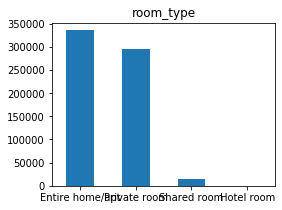

Entire home/apt    0.520216
Private room       0.456987
Shared room        0.022796
Hotel room         0.000002
Name: room_type, dtype: float64


In [21]:
for col in ['room_type']:
    category_count_plot(col, figsize=(4,3))
    print(raw_df[col].value_counts(normalize=True))

In [22]:
transformed_df = pd.get_dummies(raw_df)
transformed_df.head()

,date,id,host_id,latitude,longitude,...,neighbourhood_Woodside,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,2018-05-09,2515,2758,40.799205,-73.953676,...,0,0,1,0,0
1,2018-05-09,2539,2787,40.647486,-73.972370,...,0,0,0,1,0
2,2018-05-09,2595,2845,40.753621,-73.983774,...,0,1,0,0,0
3,2018-05-09,3330,4177,40.708558,-73.942362,...,0,0,0,1,0
4,2018-05-09,3647,4632,40.809018,-73.941902,...,0,0,0,1,0


In [23]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

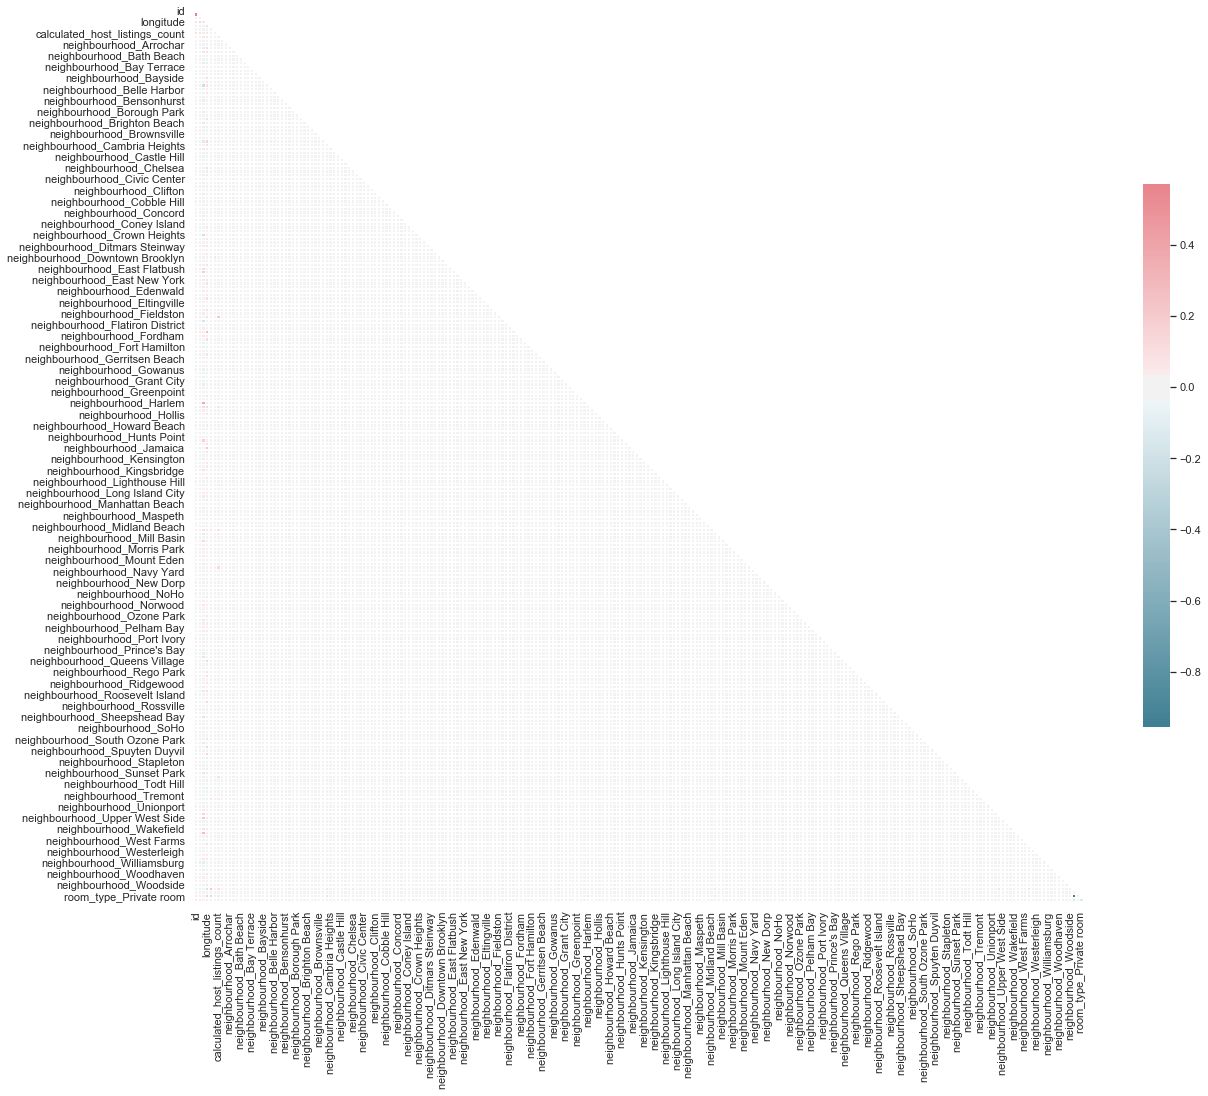

In [24]:
multi_collinearity_heatmap(transformed_df, figsize=(20,20))

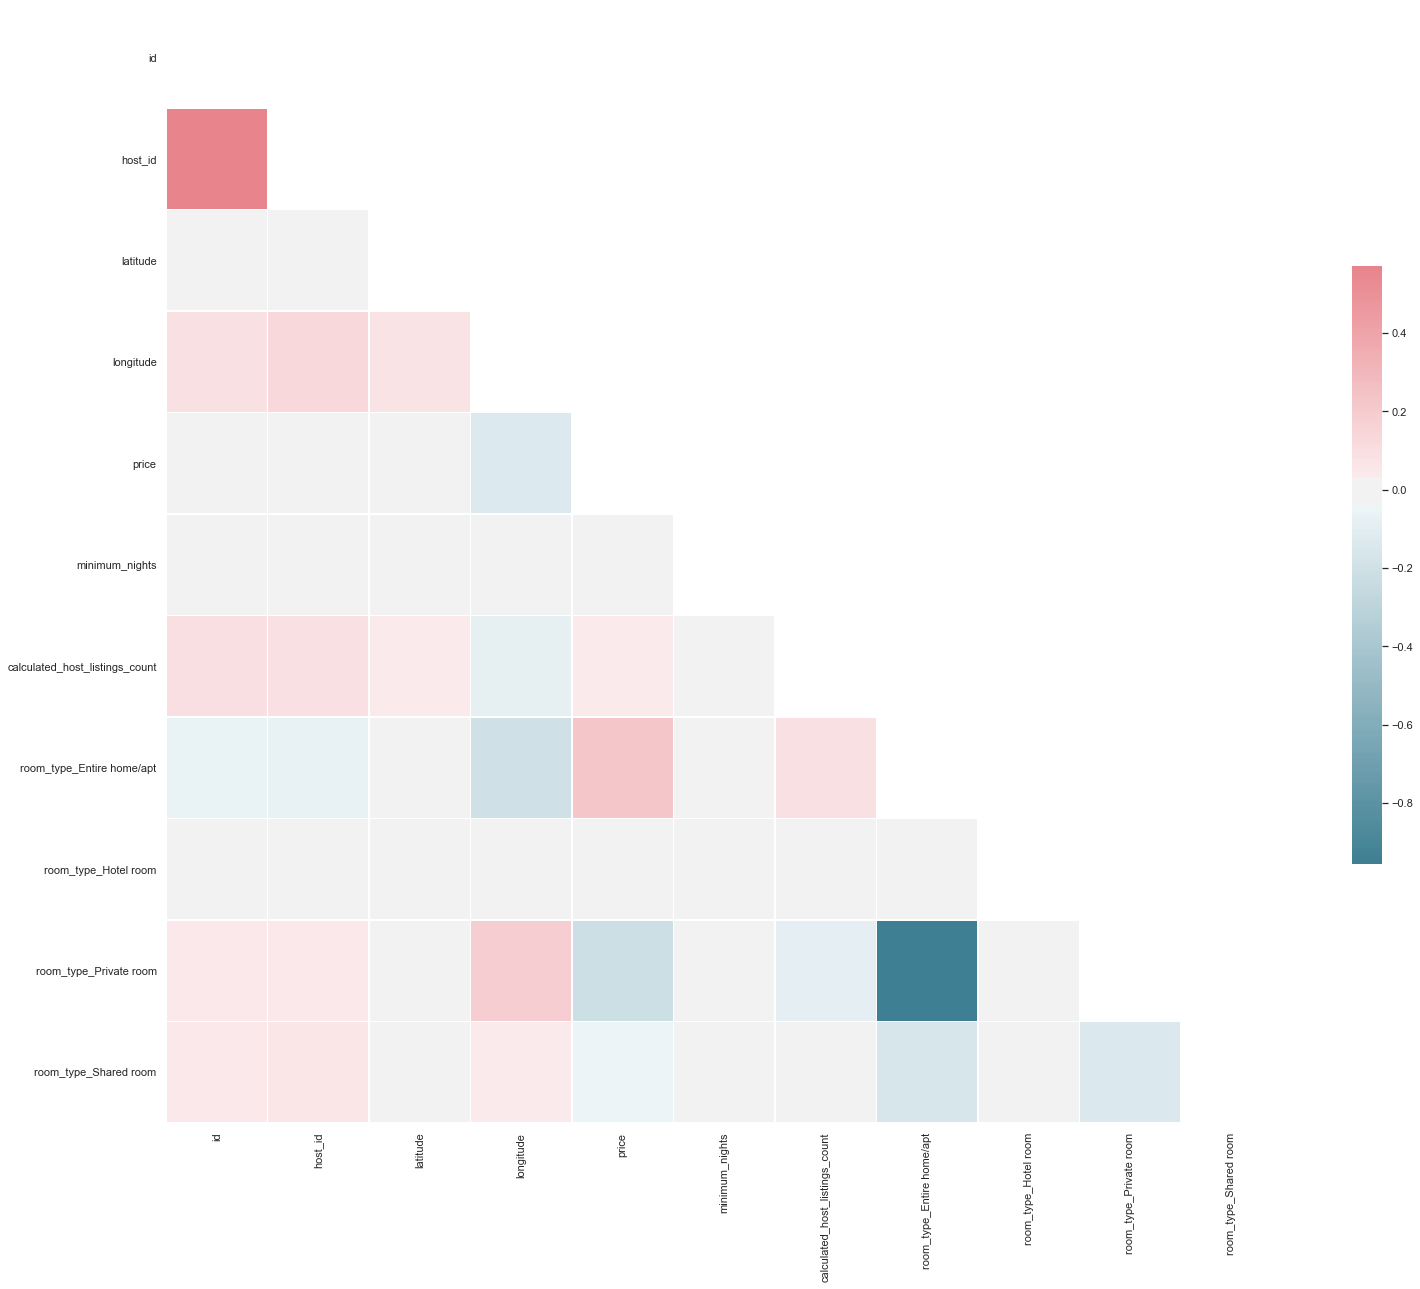

In [25]:
multi_collinearity_heatmap(transformed_df.drop(list(transformed_df.columns[transformed_df.columns.str.startswith('neighbourhood')]), axis=1), figsize=(25,22))

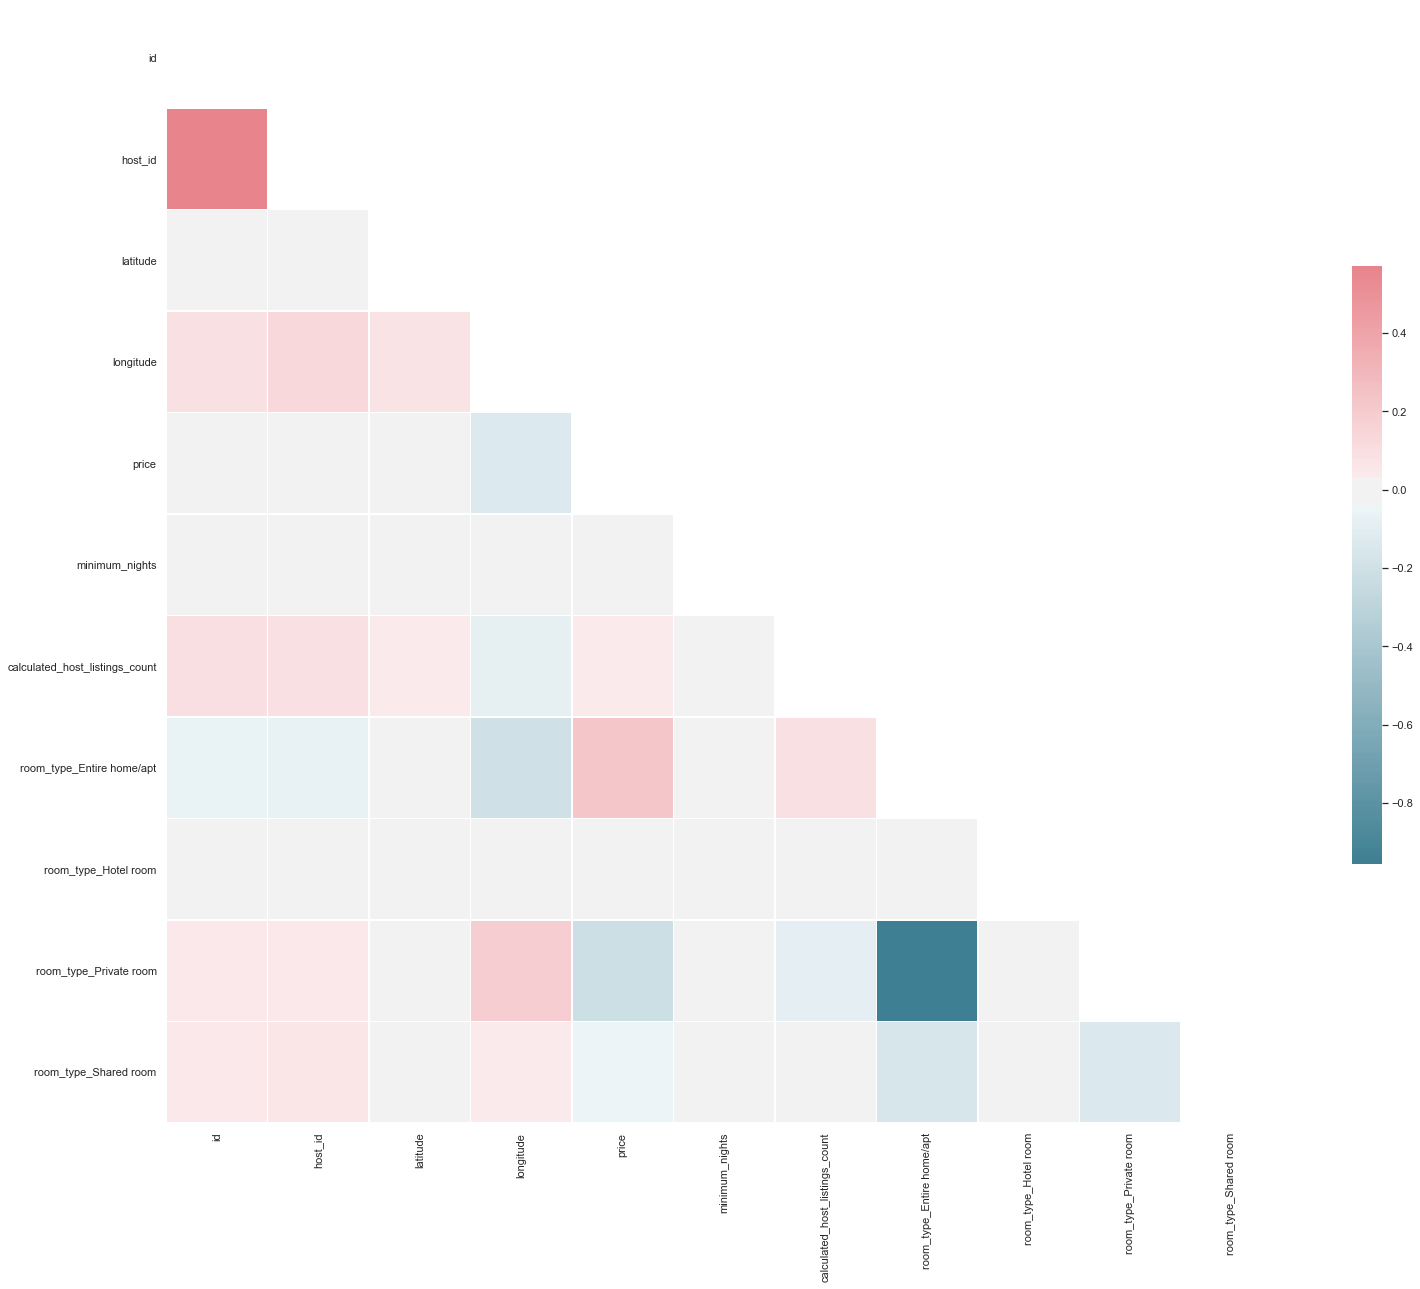

In [26]:
# Final assessment of multi-collinearity
multi_collinearity_heatmap(transformed_df.drop(list(transformed_df.columns[transformed_df.columns.str.startswith('neighbourhood')]), axis=1), figsize=(25,22))

In [27]:
numerical_columns = ['price', 'id', 'calculated_host_listings_count', 'minimum_nights', 'latitude', 'longitude']


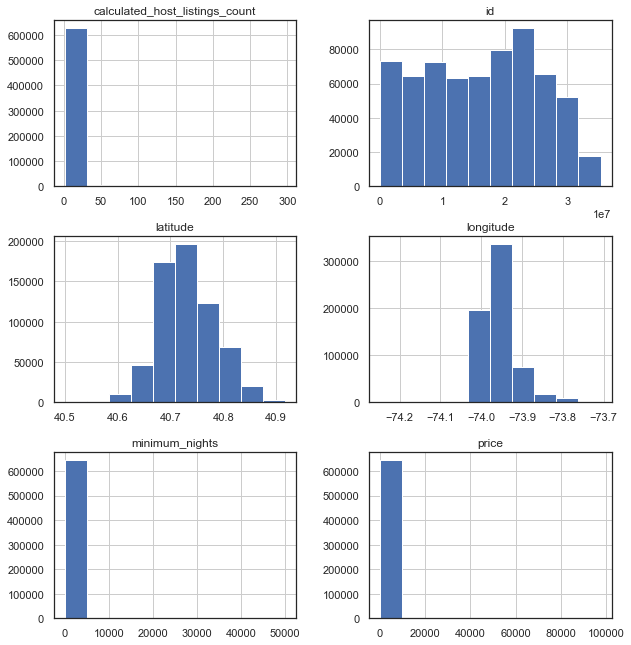

In [28]:
transformed_df[numerical_columns].hist(figsize=(10,11));

In [29]:
transformed_df['date'] = pd.to_datetime(transformed_df['date'])
transformed_df['day_of_week'] = transformed_df['date'].dt.day_name().map({"Monday":0, "Tuesday":1,"Wednesday":2,"Thursday":3,"Friday":4,"Saturday":5,"Sunday":6})

In [30]:
transformed_df.head()

,date,id,host_id,latitude,longitude,...,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,day_of_week
0,2018-05-09,2515,2758,40.799205,-73.953676,...,0,1,0,0,2
1,2018-05-09,2539,2787,40.647486,-73.972370,...,0,0,1,0,2
2,2018-05-09,2595,2845,40.753621,-73.983774,...,1,0,0,0,2
3,2018-05-09,3330,4177,40.708558,-73.942362,...,0,0,1,0,2
4,2018-05-09,3647,4632,40.809018,-73.941902,...,0,0,1,0,2


In [31]:
transformed_df["new_year_day"] = transformed_df['date'].apply(lambda x: pd.Timestamp(year=x.year, month=1, day=1))
transformed_df['day_of_the_year'] = transformed_df.apply(lambda x: (x['date'] - x['new_year_day']).days + 1, axis=1)

In [32]:
transformed_df.tail(40)

,date,id,host_id,latitude,longitude,...,room_type_Private room,room_type_Shared room,day_of_week,new_year_day,day_of_the_year
644456,2019-05-03,35275415,214738765,40.68793,-73.83383,...,0,1,4,2019-01-01,123
644457,2019-05-03,35275591,51179270,40.69704,-73.96704,...,0,0,4,2019-01-01,123
644458,2019-05-03,35275920,265576141,40.58825,-73.81208,...,1,0,4,2019-01-01,123
644459,2019-05-03,35277302,6057887,40.84853,-73.93805,...,1,0,4,2019-01-01,123
644460,2019-05-03,35277447,239989054,40.76583,-73.98943,...,0,0,4,2019-01-01,123
644461,2019-05-03,35278572,15188018,40.77867,-73.94671,...,0,0,4,2019-01-01,123
644462,2019-05-03,35278838,3644678,40.64184,-73.99102,...,1,0,4,2019-01-01,123
644463,2019-05-03,35279737,183088406,40.73513,-73.92533,...,1,0,4,2019-01-01,123
644464,2019-05-03,35280253,125441487,40.82139,-73.94291,...,0,0,4,2019-01-01,123
644465,2019-05-03,35280874,19645976,40.70912,-73.96308,...,0,0,4,2019-01-01,123


In [33]:
transformed_df['Year'] = transformed_df.new_year_day.astype(str).str[:4]
transformed_df['Year'] = transformed_df['Year'].astype(int)
transformed_df.tail()

,date,id,host_id,latitude,longitude,...,room_type_Shared room,day_of_week,new_year_day,day_of_the_year,Year
644491,2019-05-03,35291681,29731292,40.74484,-73.87696,...,0,4,2019-01-01,123,2019
644492,2019-05-03,35292625,137191484,40.76441,-73.98645,...,0,4,2019-01-01,123,2019
644493,2019-05-03,35297530,261852064,40.77233,-73.95321,...,0,4,2019-01-01,123,2019
644494,2019-05-03,35301609,158200817,40.65733,-73.95881,...,0,4,2019-01-01,123,2019
644495,2019-05-03,35303893,14034161,40.74548,-73.99703,...,0,4,2019-01-01,123,2019


In [34]:
del transformed_df['date']
del transformed_df['new_year_day']
transformed_df.head()

,id,host_id,latitude,longitude,price,...,room_type_Private room,room_type_Shared room,day_of_week,day_of_the_year,Year
0,2515,2758,40.799205,-73.953676,59,...,0,0,2,129,2018
1,2539,2787,40.647486,-73.972370,79,...,1,0,2,129,2018
2,2595,2845,40.753621,-73.983774,225,...,0,0,2,129,2018
3,3330,4177,40.708558,-73.942362,70,...,1,0,2,129,2018
4,3647,4632,40.809018,-73.941902,150,...,1,0,2,129,2018


# Machine Learning

In [35]:
# Separating X and y
X = transformed_df
y = transformed_df.price

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

In [36]:
X.head()

,id,host_id,latitude,longitude,price,...,room_type_Private room,room_type_Shared room,day_of_week,day_of_the_year,Year
0,-1.747239,-0.864368,1.288288,-0.005667,-0.339829,...,-0.917374,-0.152735,-0.796189,-0.400771,-0.788759
1,-1.747236,-0.864368,-1.524957,-0.427439,-0.265822,...,1.090068,-0.152735,-0.796189,-0.400771,-0.788759
2,-1.747230,-0.864367,0.443045,-0.684744,0.274427,...,-0.917374,-0.152735,-0.796189,-0.400771,-0.788759
3,-1.747151,-0.864346,-0.392535,0.249588,-0.299125,...,1.090068,-0.152735,-0.796189,-0.400771,-0.788759
4,-1.747117,-0.864339,1.470247,0.259972,-0.003098,...,1.090068,-0.152735,-0.796189,-0.400771,-0.788759


In [37]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

## Training Models

In [38]:
# MOST SUCCESSFUL MODEL
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

Time taken to run: 2.0 minutes

Training MSE: 0.1614
Validation MSE: 0.2418

Training r2: 1.0
Validation r2: 1.0


In [39]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)
ft_weights_xgb_reg.tail()

,weight
neighbourhood_Forest Hills,0.000089
longitude,0.000098
neighbourhood_Upper West Side,0.000155
neighbourhood_Chelsea,0.000294
price,0.998619


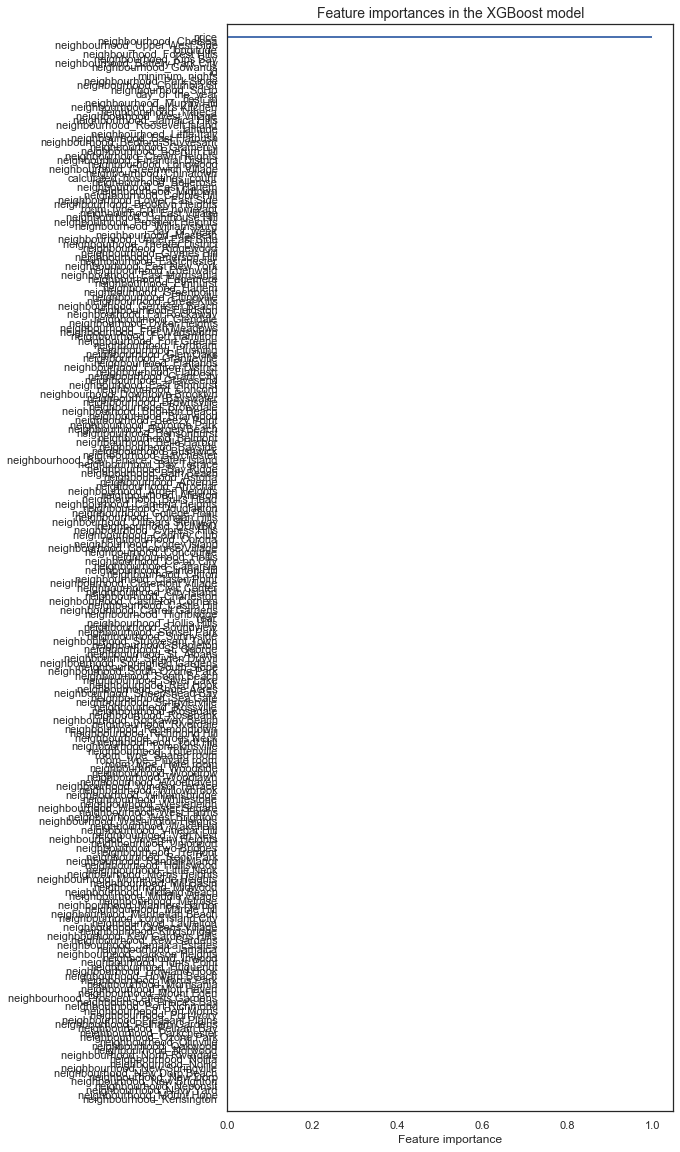

In [40]:
# Plotting feature importances
plt.figure(figsize=(8,20))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

In [41]:
print("Median number of listings per host:", int(raw_df.calculated_host_listings_count.median()))
print("Mean number of listings per host:", int(round(raw_df.calculated_host_listings_count.mean())))
print(f"{int(round(100*len(raw_df[raw_df.calculated_host_listings_count == 1])/len(raw_df)))}% of listings are from hosts with one listing.")

Median number of listings per host: 1
Mean number of listings per host: 5
67% of listings are from hosts with one listing.


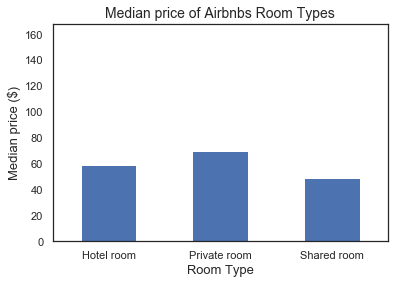

In [42]:
raw_df.groupby('room_type').price.median().plot(kind='bar')
plt.title('Median price of Airbnbs Room Types', fontsize=14)
plt.xlabel('Room Type', fontsize=13)
plt.ylabel('Median price ($)', fontsize=13)
plt.xticks(rotation=0)
plt.xlim(left=0.5)
plt.show()

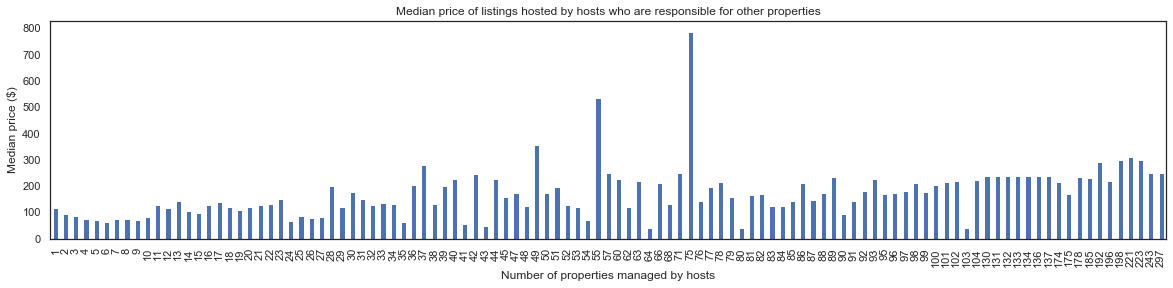

In [43]:
# Median price for different host listing counts
plt.figure()
raw_df.groupby('calculated_host_listings_count').price.median().plot(figsize=(20,4), kind='bar')
plt.title('Median price of listings hosted by hosts who are responsible for other properties')
plt.xlabel('Number of properties managed by hosts')
plt.ylabel('Median price ($)');

In [44]:
# Building the model
nn2 = models.Sequential()
nn2.add(layers.Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn2.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn2.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               31104     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 130,177
Trainable params: 130,177
Non-trainable params: 0
_________________________________________________________________
None


In [45]:
# Training the model
nn2_start = time.time()

nn2_history = nn2.fit(X_train,
                  y_train,
                  epochs=15,
                  batch_size=256,
                  validation_split = 0.1)

nn2_end = time.time()

print(f"Time taken to run: {round((nn2_end - nn2_start)/60,1)} minutes")

Epoch 1/15
1813/1813 [==============================] - 4s 2ms/step - loss: 5265.3442 - mean_squared_error: 5265.3442 - val_loss: 1535.8877 - val_mean_squared_error: 1535.8877
Epoch 2/15
1813/1813 [==============================] - 4s 2ms/step - loss: 335.8172 - mean_squared_error: 335.8172 - val_loss: 184.8965 - val_mean_squared_error: 184.8965
Epoch 3/15
1813/1813 [==============================] - 3s 2ms/step - loss: 197.9702 - mean_squared_error: 197.9702 - val_loss: 153.2543 - val_mean_squared_error: 153.2543
Epoch 4/15
1813/1813 [==============================] - 3s 2ms/step - loss: 190.2297 - mean_squared_error: 190.2297 - val_loss: 156.2728 - val_mean_squared_error: 156.2728
Epoch 5/15
1813/1813 [==============================] - 4s 2ms/step - loss: 464.5582 - mean_squared_error: 464.5582 - val_loss: 146.8865 - val_mean_squared_error: 146.8865
Epoch 6/15
1813/1813 [==============================] - 4s 2ms/step - loss: 445.0749 - mean_squared_error: 445.0749 - val_loss: 148.8324

In [46]:
def nn_model_evaluation(model, skip_epochs=0, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    """
    For a given neural network model that has already been fit, prints for the train and tests sets the MSE and r squared
    values, a line graph of the loss in each epoch, and a scatterplot of predicted vs. actual values with a line
    representing where predicted = actual values. Optionally, a value for skip_epoch can be provided, which skips that
    number of epochs in the line graph of losses (useful in cases where the loss in the first epoch is orders of magnitude
    larger than subsequent epochs). Training and test sets can also optionally be specified.
    """

    # MSE and r squared values
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    print("Training MSE:", round(mean_squared_error(y_train, y_train_pred),4))
    print("Validation MSE:", round(mean_squared_error(y_test, y_test_pred),4))
    print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
    print("Validation r2:", round(r2_score(y_test, y_test_pred),4))
    
#     # Line graph of losses
#     model_results = model.history.history
#     plt.plot(list(range((skip_epochs+1),len(model_results['loss'])+1)), model_results['loss'][skip_epochs:], label='Train')
#     plt.plot(list(range((skip_epochs+1),len(model_results['val_loss'])+1)), model_results['val_loss'][skip_epochs:], label='Test', color='green')
#     plt.legend()
#     plt.title('Training and test loss at each epoch', fontsize=14)
#     plt.show()
    
    # Scatterplot of predicted vs. actual values
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Predicted vs. actual values', fontsize=14, y=1)
    plt.subplots_adjust(top=0.93, wspace=0)
    
    ax1.scatter(y_test, y_test_pred, s=2, alpha=0.7)
    ax1.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax1.set_title('Test set')
    ax1.set_xlabel('Actual values')
    ax1.set_ylabel('Predicted values')
    
    ax2.scatter(y_train, y_train_pred, s=2, alpha=0.7)
    ax2.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax2.set_title('Train set')
    ax2.set_xlabel('Actual values')
    ax2.set_ylabel('')
    ax2.set_yticklabels(labels='')
    
    plt.show()

Training MSE: 49.0188
Validation MSE: 66.6362

Training r2: 0.9994
Validation r2: 0.9986


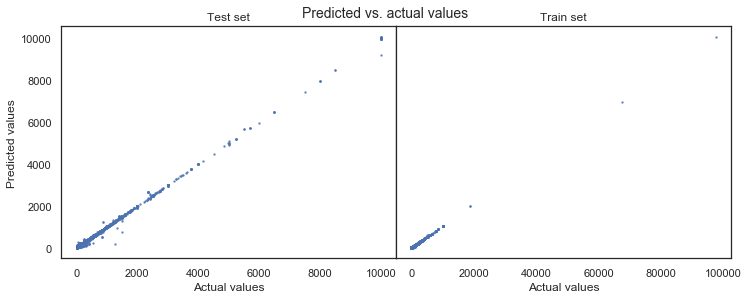

In [47]:
nn_model_evaluation(nn2)


In [48]:
# Building the model
nn3 = models.Sequential()
nn3.add(layers.Dense(128, input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn3.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn3.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               31104     
_________________________________________________________________
dense_5 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_6 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_7 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
Total params: 262,017
Trainable params: 262,017
Non-trainable params: 0
_________________________________________________________________
None


In [49]:
# Training the model
nn3_start = time.time()

nn3_history = nn3.fit(X_train,
                  y_train,
                  epochs=15,
                  batch_size=256,
                  validation_split = 0.1)

nn3_end = time.time()

print(f"Time taken to run: {round((nn3_end - nn3_start)/60,1)} minutes")


Epoch 1/15
1813/1813 [==============================] - 8s 4ms/step - loss: 6051.3159 - mean_squared_error: 5989.7305 - val_loss: 326.6801 - val_mean_squared_error: 265.8936
Epoch 2/15
1813/1813 [==============================] - 8s 4ms/step - loss: 463.5343 - mean_squared_error: 403.6645 - val_loss: 343.5504 - val_mean_squared_error: 284.2870
Epoch 3/15
1813/1813 [==============================] - 8s 4ms/step - loss: 269.6100 - mean_squared_error: 211.3939 - val_loss: 300.5187 - val_mean_squared_error: 243.5429
Epoch 4/15
1813/1813 [==============================] - 8s 4ms/step - loss: 1781.3734 - mean_squared_error: 1723.3922 - val_loss: 379.6747 - val_mean_squared_error: 323.2365
Epoch 5/15
1813/1813 [==============================] - 8s 4ms/step - loss: 589.7023 - mean_squared_error: 535.2321 - val_loss: 241.2969 - val_mean_squared_error: 189.4233
Epoch 6/15
1813/1813 [==============================] - 7s 4ms/step - loss: 1232.1755 - mean_squared_error: 1182.3104 - val_loss: 165.07

Training MSE: 125.857
Validation MSE: 136.7886

Training r2: 0.9984
Validation r2: 0.9972


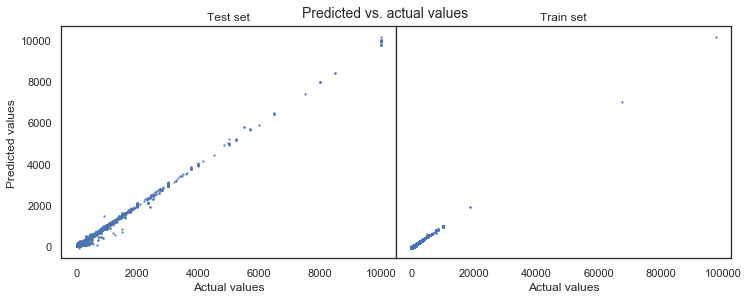

In [50]:
# Evaluating the model
nn_model_evaluation(nn3, skip_epochs=2)

In [51]:
# Building the model
nn4 = models.Sequential()
nn4.add(layers.Dense(128, input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn4.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn4.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn4.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn4.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn4.compile(loss='mean_squared_error',
            optimizer='SGD',
            metrics=['mean_squared_error'])

# Model summary
print(nn4.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 128)               31104     
_________________________________________________________________
dense_10 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_11 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_12 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 513       
Total params: 262,017
Trainable params: 262,017
Non-trainable params: 0
_________________________________________________________________
None


In [52]:
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

Time taken to run: 1.8 minutes

Training MSE: 0.1614
Validation MSE: 0.2418

Training r2: 1.0
Validation r2: 1.0


In [53]:
# nn_model_evaluation(nn4, skip_epochs=10) # This model took several epochs before the loss was in a similar range to other models

In [54]:
nn5 = models.Sequential()
nn5.add(layers.Dropout(0.5, input_shape=(X_train.shape[1],)))
nn5.add(layers.Dense(128, activation='relu'))
nn5.add(layers.Dropout(0.5))
nn5.add(layers.Dense(256, activation='relu'))
nn5.add(layers.Dropout(0.5))
nn5.add(layers.Dense(512, activation='relu'))
nn5.add(layers.Dropout(0.5))
nn5.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn5.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn5.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 242)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               31104     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

In [55]:
# Training the model
nn5_start = time.time()

nn5_history = nn5.fit(X_train,
                  y_train,
                  epochs=15,
                  batch_size=256,
                  validation_split = 0.1)

nn5_end = time.time()

print(f"Time taken to run: {round((nn5_end - nn5_start)/60,1)} minutes")

Epoch 1/15
1813/1813 [==============================] - 6s 3ms/step - loss: 51206.8867 - mean_squared_error: 51206.8867 - val_loss: 15823.4131 - val_mean_squared_error: 15823.4131
Epoch 2/15
1813/1813 [==============================] - 6s 3ms/step - loss: 55022.4844 - mean_squared_error: 55022.4844 - val_loss: 15129.6064 - val_mean_squared_error: 15129.6064
Epoch 3/15
1813/1813 [==============================] - 6s 3ms/step - loss: 34007.7812 - mean_squared_error: 34007.7812 - val_loss: 17679.8555 - val_mean_squared_error: 17679.8555
Epoch 4/15
1813/1813 [==============================] - 6s 3ms/step - loss: 56688.8438 - mean_squared_error: 56688.8438 - val_loss: 15678.6357 - val_mean_squared_error: 15678.6357
Epoch 5/15
1813/1813 [==============================] - 6s 3ms/step - loss: 57331.0938 - mean_squared_error: 57331.0938 - val_loss: 16612.0918 - val_mean_squared_error: 16612.0918
Epoch 6/15
1813/1813 [==============================] - 6s 3ms/step - loss: 35988.0039 - mean_square

Training MSE: 22740.2259
Validation MSE: 14544.8506

Training r2: 0.7122
Validation r2: 0.7037


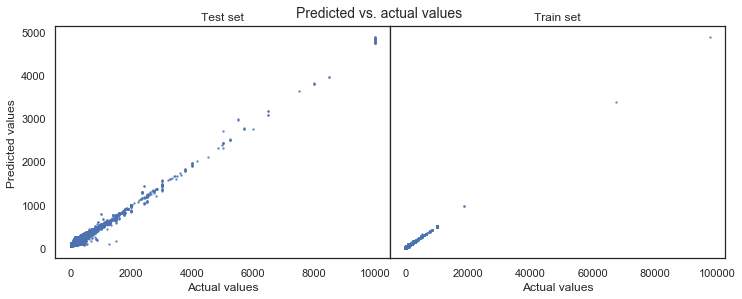

In [56]:
nn_model_evaluation(nn5, skip_epochs=2)

In [57]:
nn6 = models.Sequential()
nn6.add(layers.Dropout(0.2, input_shape=(X_train.shape[1],)))
nn6.add(layers.Dense(128, activation='relu'))
nn6.add(layers.Dropout(0.2))
nn6.add(layers.Dense(256, activation='relu'))
nn6.add(layers.Dropout(0.2))
nn6.add(layers.Dense(512, activation='relu'))
nn6.add(layers.Dropout(0.2))
nn6.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn6.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn6.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_4 (Dropout)          (None, 242)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               31104     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)              

In [58]:
# Training the model
nn6_start = time.time()

nn6_history = nn6.fit(X_train,
                  y_train,
                  epochs=15,
                  batch_size=512,
                  validation_split = 0.1)

nn6_end = time.time()

print(f"Time taken to run: {round((nn6_end - nn6_start)/60,1)} minutes")

Epoch 1/15
907/907 [==============================] - 5s 6ms/step - loss: 26326.3086 - mean_squared_error: 26326.3086 - val_loss: 3205.5630 - val_mean_squared_error: 3205.5630
Epoch 2/15
907/907 [==============================] - 5s 5ms/step - loss: 13099.3057 - mean_squared_error: 13099.3057 - val_loss: 3276.4695 - val_mean_squared_error: 3276.4695
Epoch 3/15
907/907 [==============================] - 5s 5ms/step - loss: 10906.5537 - mean_squared_error: 10906.5537 - val_loss: 3347.6567 - val_mean_squared_error: 3347.6567
Epoch 4/15
907/907 [==============================] - 5s 6ms/step - loss: 31221.4434 - mean_squared_error: 31221.4434 - val_loss: 3467.5989 - val_mean_squared_error: 3467.5989
Epoch 5/15
907/907 [==============================] - 5s 6ms/step - loss: 10292.6621 - mean_squared_error: 10292.6621 - val_loss: 2291.5090 - val_mean_squared_error: 2291.5090
Epoch 6/15
907/907 [==============================] - 5s 6ms/step - loss: 11524.7842 - mean_squared_error: 11524.7842 - 

Training MSE: 3842.6236
Validation MSE: 2661.748

Training r2: 0.9514
Validation r2: 0.9458


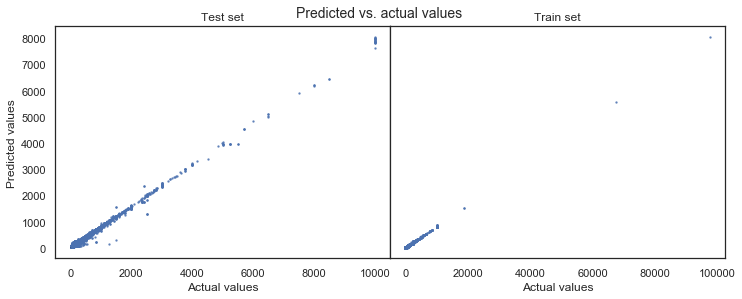

In [59]:
nn_model_evaluation(nn6)

## Testing Models

The most successful model was the XGBoost Regression model.

In [74]:
test_dataset = pd.read_csv("data/NYC_Jun19May20.csv")
print(f"The dataset contains {len(raw_df)} Airbnb listings")
pd.set_option('display.max_columns', len(raw_df.columns)) # To view all columns
pd.set_option('display.max_rows', 100)
raw_df.head(3)

The dataset contains 644496 Airbnb listings


,date,id,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count
0,2018-05-09,2515,2758,Harlem,40.799205,-73.953676,Hotel room,59,2,3
1,2018-05-09,2539,2787,Kensington,40.647486,-73.972370,Private room,79,1,7
2,2018-05-09,2595,2845,Midtown,40.753621,-73.983774,Entire home/apt,225,1,2


In [75]:
test_dataset.date = pd.to_datetime(test_dataset.date) 
test_dataset=test_dataset.dropna()

In [76]:
test_dataset.isna().sum()

Unnamed: 0                        0
date                              0
id                                0
host_id                           0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
calculated_host_listings_count    0
dtype: int64

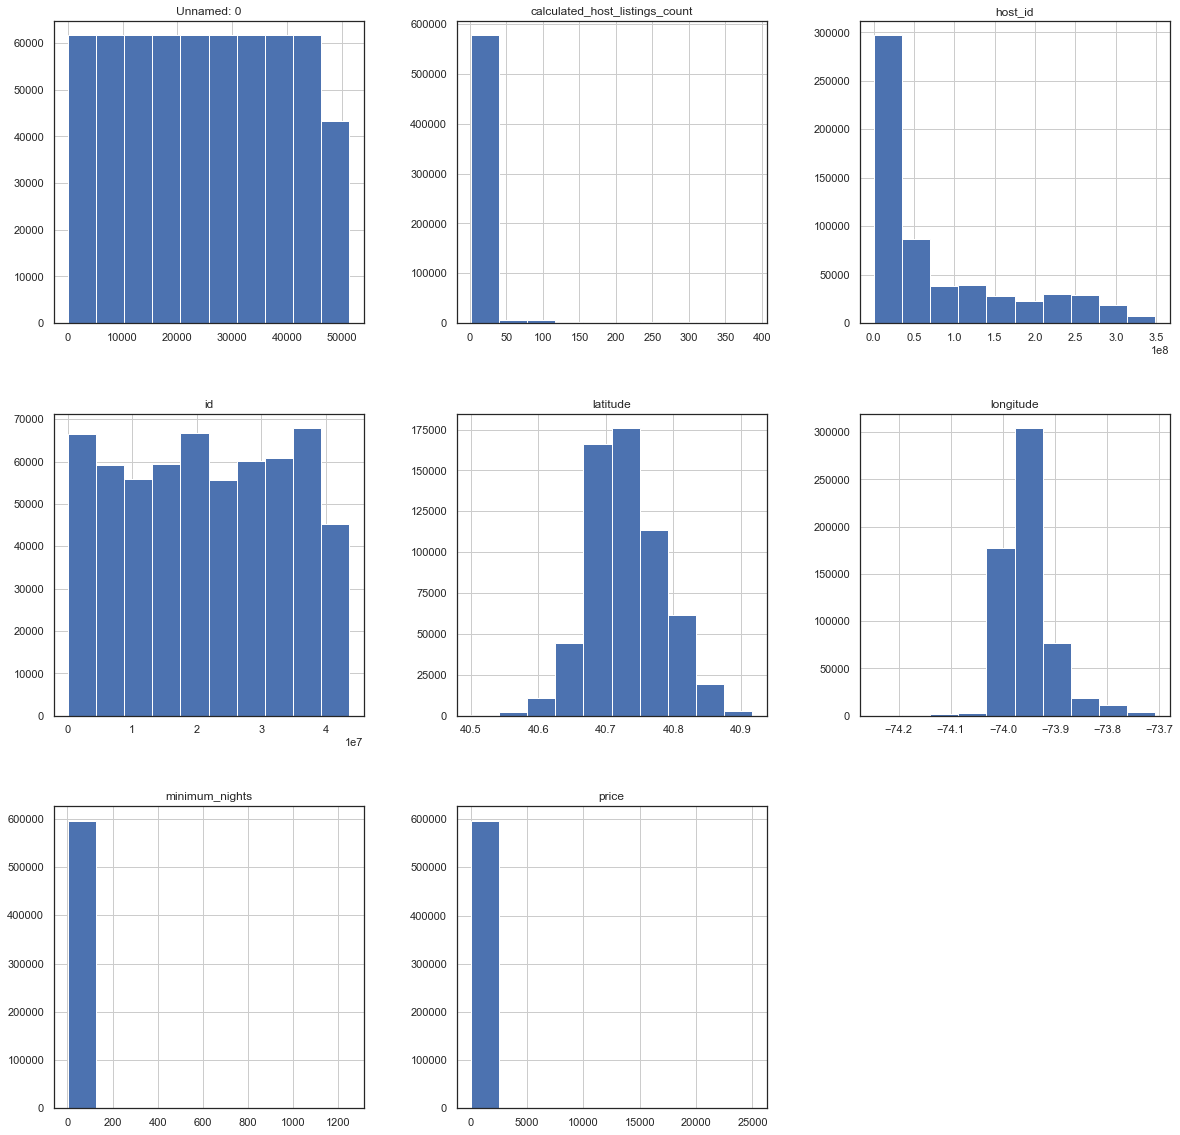

In [77]:
# Replacing columns with f/t with 0/1
test_dataset.replace({'f': 0, 't': 1}, inplace=True)

# Plotting the distribution of numerical and boolean categories
test_dataset.hist(figsize=(20,20));

In [78]:
transformed_test = pd.get_dummies(test_dataset)
transformed_test.head()

,Unnamed: 0,date,id,host_id,latitude,...,neighbourhood_Woodside,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,0,2019-06-02,2539,2787,40.64749,...,0,0,0,1,0
1,1,2019-06-02,2595,2845,40.75362,...,0,1,0,0,0
2,2,2019-06-02,3647,4632,40.80902,...,0,0,0,1,0
3,3,2019-06-02,3831,4869,40.68514,...,0,1,0,0,0
4,4,2019-06-02,5022,7192,40.79851,...,0,1,0,0,0


In [79]:
transformed_test.dtypes

Unnamed: 0                            int64
date                         datetime64[ns]
id                                    int64
host_id                               int64
latitude                            float64
                                  ...      
neighbourhood_Woodside                uint8
room_type_Entire home/apt             uint8
room_type_Hotel room                  uint8
room_type_Private room                uint8
room_type_Shared room                 uint8
Length: 241, dtype: object

In [80]:
transformed_test["new_year_day"] = transformed_test['date'].apply(lambda x: pd.Timestamp(year=x.year, month=1, day=1))
transformed_test['day_of_the_year'] = transformed_test.apply(lambda x: (x['date'] - x['new_year_day']).days + 1, axis=1)

In [81]:
transformed_test['date'] = pd.to_datetime(transformed_test['date'])
transformed_test['day_of_week'] = transformed_test['date'].dt.day_name().map({"Monday":0, "Tuesday":1,"Wednesday":2,"Thursday":3,"Friday":4,"Saturday":5,"Sunday":6})

In [82]:
transformed_test['Year'] = transformed_test.new_year_day.astype(str).str[:4]
transformed_test['Year'] = transformed_test['Year'].astype(int)
transformed_test.tail()

,Unnamed: 0,date,id,host_id,latitude,...,room_type_Shared room,new_year_day,day_of_the_year,day_of_week,Year
598021,49525,2020-05-06,43702714,18880232,40.729553,...,0,2020-01-01,127,2,2020
598022,49526,2020-05-06,43702765,804056,40.697820,...,0,2020-01-01,127,2,2020
598023,49527,2020-05-06,43703128,137358866,40.812614,...,0,2020-01-01,127,2,2020
598024,49528,2020-05-06,43703156,26846438,40.713753,...,0,2020-01-01,127,2,2020
598025,49529,2020-05-06,43703359,348619646,40.747453,...,0,2020-01-01,127,2,2020


In [83]:
del transformed_test['Unnamed: 0']
transformed_test.head()

,date,id,host_id,latitude,longitude,...,room_type_Shared room,new_year_day,day_of_the_year,day_of_week,Year
0,2019-06-02,2539,2787,40.64749,-73.97237,...,0,2019-01-01,153,6,2019
1,2019-06-02,2595,2845,40.75362,-73.98377,...,0,2019-01-01,153,6,2019
2,2019-06-02,3647,4632,40.80902,-73.94190,...,0,2019-01-01,153,6,2019
3,2019-06-02,3831,4869,40.68514,-73.95976,...,0,2019-01-01,153,6,2019
4,2019-06-02,5022,7192,40.79851,-73.94399,...,0,2019-01-01,153,6,2019


In [84]:
transformed_test=transformed_test.drop(['new_year_day'], axis=1)
transformed_test.head()

,date,id,host_id,latitude,longitude,...,room_type_Private room,room_type_Shared room,day_of_the_year,day_of_week,Year
0,2019-06-02,2539,2787,40.64749,-73.97237,...,1,0,153,6,2019
1,2019-06-02,2595,2845,40.75362,-73.98377,...,0,0,153,6,2019
2,2019-06-02,3647,4632,40.80902,-73.94190,...,1,0,153,6,2019
3,2019-06-02,3831,4869,40.68514,-73.95976,...,0,0,153,6,2019
4,2019-06-02,5022,7192,40.79851,-73.94399,...,0,0,153,6,2019


In [85]:
del transformed_test['date']
transformed_test.head()

,id,host_id,latitude,longitude,price,...,room_type_Private room,room_type_Shared room,day_of_the_year,day_of_week,Year
0,2539,2787,40.64749,-73.97237,149,...,1,0,153,6,2019
1,2595,2845,40.75362,-73.98377,225,...,0,0,153,6,2019
2,3647,4632,40.80902,-73.94190,150,...,1,0,153,6,2019
3,3831,4869,40.68514,-73.95976,89,...,0,0,153,6,2019
4,5022,7192,40.79851,-73.94399,80,...,0,0,153,6,2019


In [86]:
transformed_test = transformed_test[transformed_df.columns]
transformed_test.head()

,id,host_id,latitude,longitude,price,...,room_type_Private room,room_type_Shared room,day_of_week,day_of_the_year,Year
0,2539,2787,40.64749,-73.97237,149,...,1,0,6,153,2019
1,2595,2845,40.75362,-73.98377,225,...,0,0,6,153,2019
2,3647,4632,40.80902,-73.94190,150,...,1,0,6,153,2019
3,3831,4869,40.68514,-73.95976,89,...,0,0,6,153,2019
4,5022,7192,40.79851,-73.94399,80,...,0,0,6,153,2019


In [ ]:
transformed_test['Prediction'] = np.expm1(xgb_reg.predict(transformed_test[ft_weights_xgb_reg]))
filename = 'data/NYC_prediction.csv'
pd.DataFrame({'id': transformed_test.id, 'price': transformed_test.Prediction}).to_csv(filename, index=False)